In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
import math
from statsmodels.tsa.stattools import adfuller
import statsmodels
from statsmodels.tsa.arima_model import ARIMA
import sklearn
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import pmdarima as pm
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error,mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import package_name

# functions

In [3]:
def create_features(df, x):
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['quarter'] = df.index.quarter
    df['day_of_year'] = df.index.dayofyear
    df['lag_1'] = df[x].shift(1)
    return df

In [4]:
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
from math import sqrt

def eval_metrics(actual, forecast):
    actual = np.array(actual)
    forecast = np.array(forecast)  
    n = len(actual)
    mape = mean_absolute_percentage_error(actual, forecast)
    smape = (100/n) * np.sum(2 * np.abs(forecast - actual) / (np.abs(actual) + np.abs(forecast)))
    mae = mean_absolute_error(actual, forecast)
    rmse = sqrt(mean_squared_error(actual, forecast))
    return mape, smape, mae, rmse


#     mae = np.abs(forecast - actual).mean()
#     mape = np.mean(np.abs((actual - abs(forecast)) / actual) * 100)
#     rmse = np.sqrt(np.mean((forecast - actual) ** 2))

In [5]:
plt.style.use('fivethirtyeight')

In [6]:
import warnings
warnings.filterwarnings('ignore')

# Read Data

In [7]:
df = pd.read_excel('UoS Energy Consumption.xlsx', sheet_name='total consmp_for_forecast')

In [8]:
df.head(5)

,date_time,consumption
0,2005-07-01,1227356.0
1,2005-08-01,1189818.0
2,2005-09-01,1271609.0
3,2005-10-01,1553131.0
4,2005-11-01,1557021.0


In [9]:
df = df[['date_time', 'consumption']]

In [10]:
df.head(5)

,date_time,consumption
0,2005-07-01,1227356.0
1,2005-08-01,1189818.0
2,2005-09-01,1271609.0
3,2005-10-01,1553131.0
4,2005-11-01,1557021.0


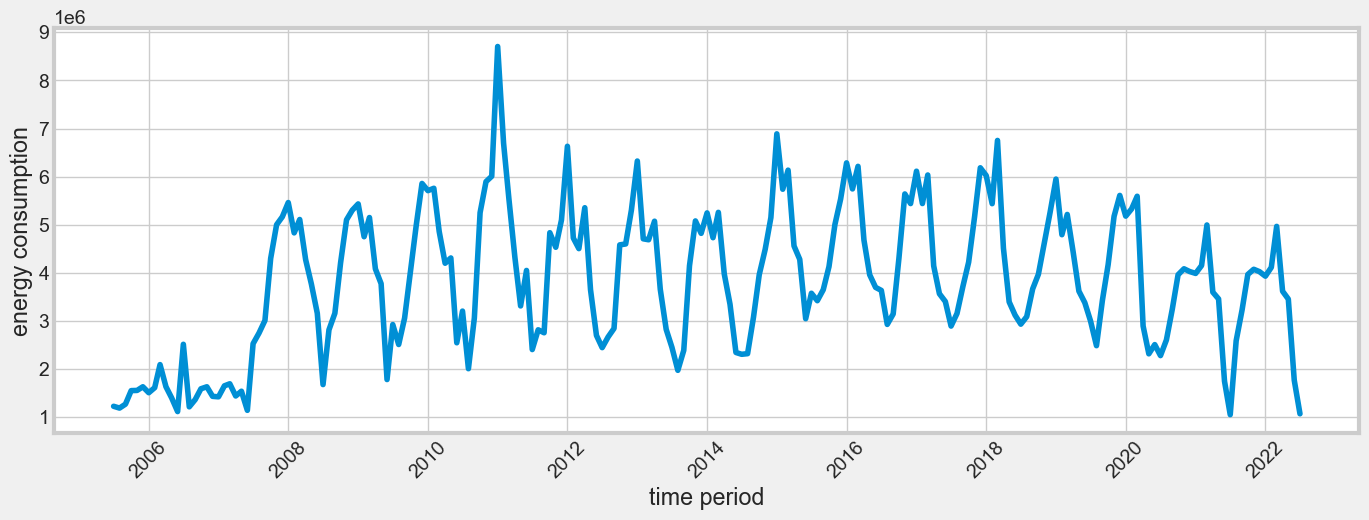

In [11]:
plt.figure(figsize=(15, 5))
sns.set_style('whitegrid')
sns.lineplot(x='date_time', y='consumption', data=df)
plt.xlabel("time period")
plt.ylabel("energy consumption")
plt.xticks(rotation=45)
plt.show()

# Date Index

In [12]:
df = df[df['date_time'] >= '2009-01-01']

In [13]:
df = df.set_index('date_time')
df.head(2)

,consumption
date_time,
2009-01-01,5.434464e+06
2009-02-01,4.752303e+06


# Feature Selection

In [14]:
df = create_features(df, 'consumption')

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 163 entries, 2009-01-01 to 2022-07-01
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   consumption  163 non-null    float64
 1   day_of_week  163 non-null    int64  
 2   month        163 non-null    int64  
 3   year         163 non-null    int64  
 4   quarter      163 non-null    int64  
 5   day_of_year  163 non-null    int64  
 6   lag_1        162 non-null    float64
dtypes: float64(2), int64(5)
memory usage: 10.2 KB


# Feature Selection

In [16]:
correlations = df.corr()

print("Correlations with Target:")
print(correlations['consumption'])

Correlations with Target:
consumption    1.000000
day_of_week    0.028226
month         -0.254260
year          -0.141330
quarter       -0.254513
day_of_year   -0.252125
lag_1          0.734632
Name: consumption, dtype: float64


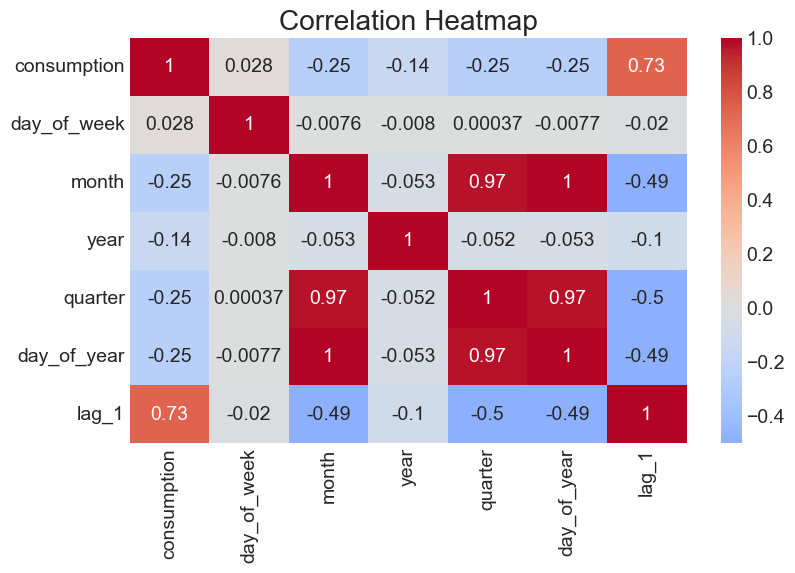

In [17]:
plt.figure(figsize=(8, 5))
sns.heatmap(correlations, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap")
plt.show()

In [18]:
corr_with_target = correlations['consumption'][['day_of_week', 'month', 'year', 'quarter', 'day_of_year']]
# 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5'
selected_cols = corr_with_target.sort_values(ascending=False).index[:5]
selected_cols

Index(['day_of_week', 'year', 'day_of_year', 'month', 'quarter'], dtype='object')

# X and Y

In [19]:
# 'day_of_year' has not been selected after hypertuning

y = df['consumption']
X = df[['day_of_week', 'year', 'month', 'quarter']]

# Train Test Split with Time Series Split  Cross-Validation

In [20]:
# training_limit = int( 0.80 * len(df))
# train_data = df[:training_limit]
# test_data = df[training_limit:]

# Time Series Split 5-fold Cross-Validation

from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

for train_index, test_index in tscv.split(y):
    y_train = y[train_index]
    y_test = y[test_index]
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]

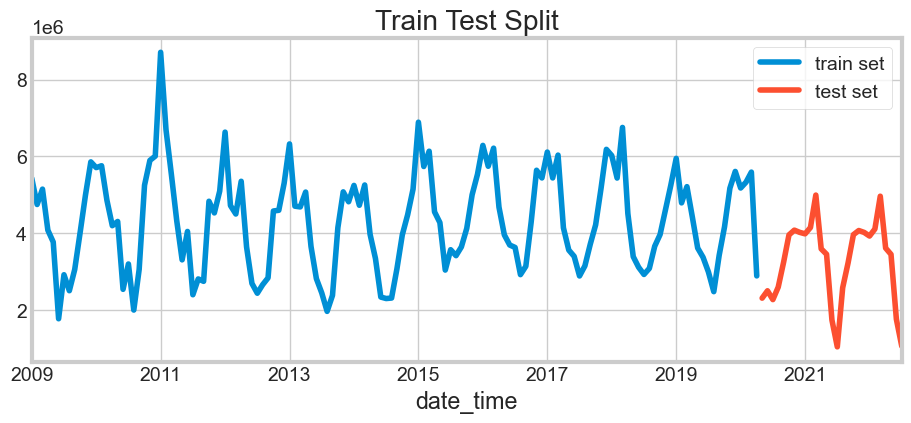

In [21]:
plt.figure(figsize=(10, 4))
y_train.plot(label='train set')
y_test.plot(label='test set')
plt.title('Train Test Split')
plt.legend()

In [22]:
# X_train.tail(5)

In [23]:
# X_train.head(5)

# Anomalies on Training Data

In [24]:
y_train_arr = y_train.to_numpy()
y_train_reshape = y_train_arr.reshape(-1, 1)

In [25]:
from sklearn.ensemble import IsolationForest

anom_model = IsolationForest(contamination=0.05, random_state=42)
anom_predictions = anom_model.fit_predict(y_train_reshape)

In [26]:
is_anom = anom_predictions == -1
# is_anom

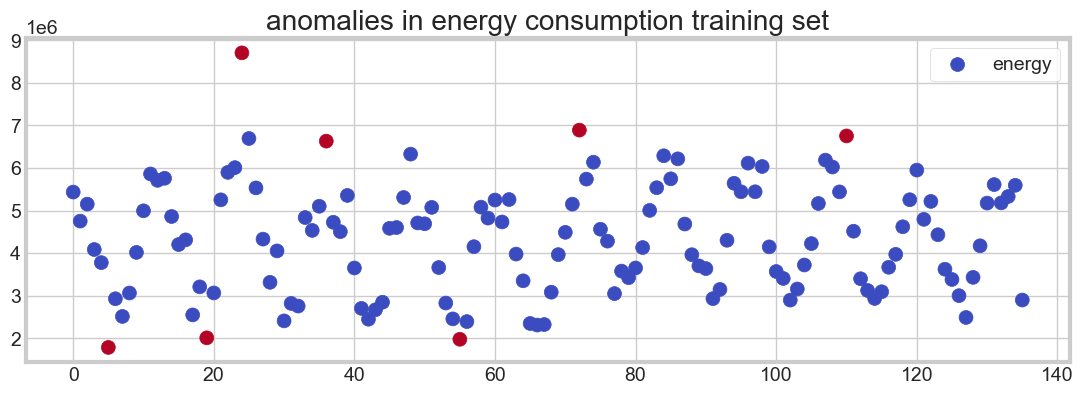

In [27]:
plt.figure(figsize=(12, 4))
plt.scatter(range(len(y_train_reshape)), y_train_reshape, c=is_anom, cmap='coolwarm', s=100)

plt.title('anomalies in energy consumption training set')
plt.legend(['energy', 'anomaly'], loc='upper right')
plt.show()

# Removing Anomalies with ffill values

In [28]:
y_train_with_anom = y_train.copy()

In [29]:
y_train_with_anom[is_anom] = np.nan
y_train_with_anom.fillna(method='ffill', inplace=True)

## Moving Average

In [30]:
# train_data['total ene'].rolling(12).mean().tail(60)
# train_data['total ene'].rolling(12).std()

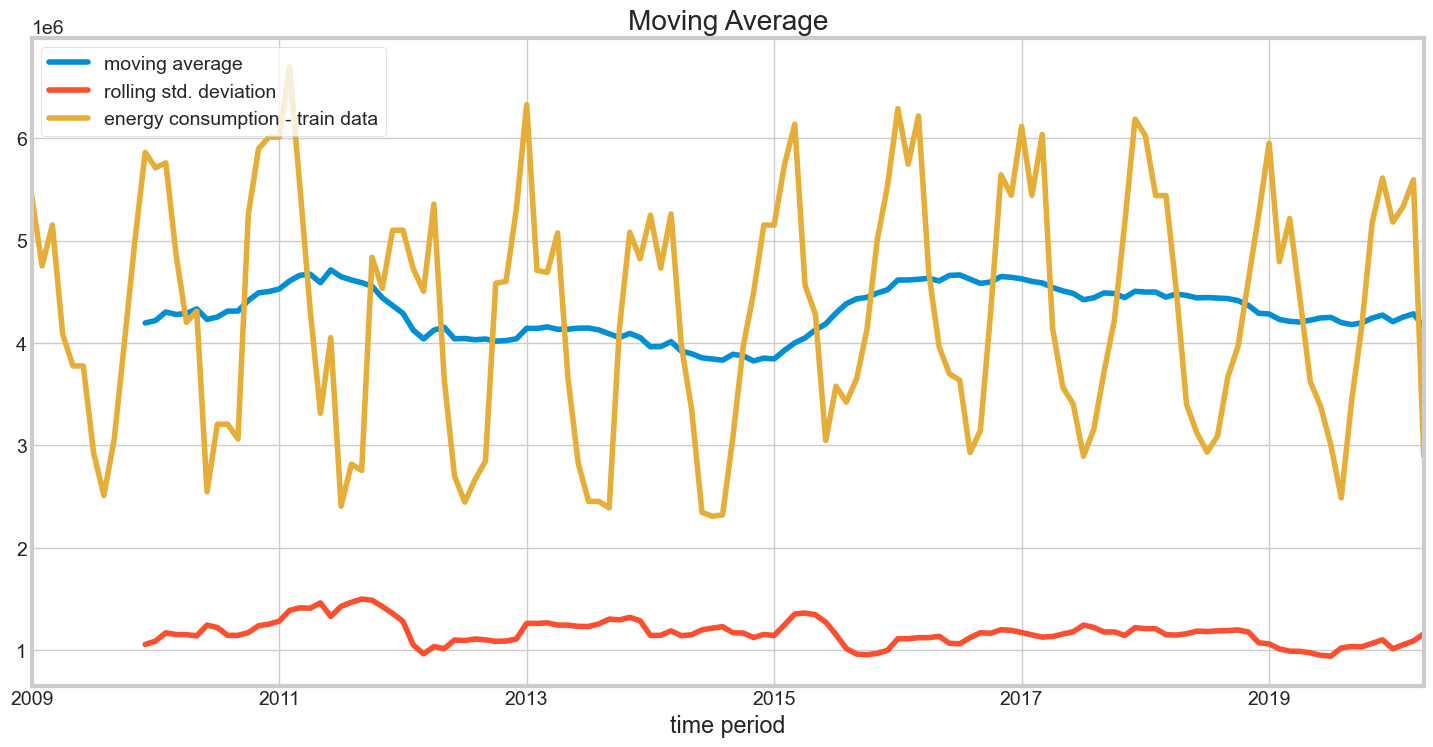

In [31]:
y_train_with_anom.rolling(12).mean().plot(label='moving average',figsize=(16,8))
y_train_with_anom.rolling(12).std().plot(label='rolling std. deviation')
y_train_with_anom.plot(label='energy consumption - train data')
plt.title("Moving Average")
plt.xlabel("time period")
plt.legend()

## Decomposition to its trend, seasonality and residual components

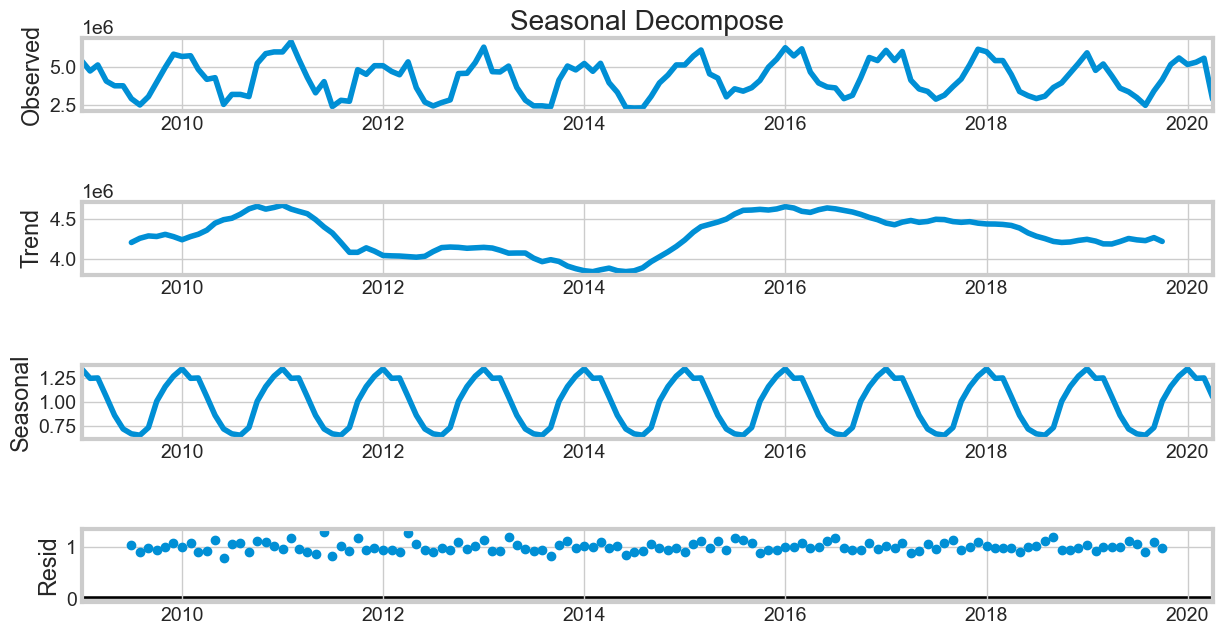

In [32]:
# from statsmodels.tsa.seasonal import seasonal_decompose

decompose = seasonal_decompose(y_train_with_anom, model='multiplicative', period=12)
fig = decompose.plot()
fig.set_size_inches(14,7)
fig.axes[0].set_title("Seasonal Decompose")
fig.axes[0].set_ylabel("Observed")
plt.show()

## deseasonalize - not performed

In [33]:
# y_train = y_train - decompose.seasonal
# y_train.tail(5)

In [34]:
# fig, ax = plt.subplots()
# y_train.plot(ax=ax)
# fig.set_size_inches(14, 7)
# ax.set_title("Deseasonalized Time Series")
# ax.set_ylabel("Value")
# plt.show()

## Stationary Test

In [35]:
#Augmented Dickey-fuller test
adf = adfuller(y_train,autolag='AIC')
dfoutput=pd.Series(adf[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])

for key,value in adf[4].items():
    dfoutput['critical value (%s)'%key]= value
print(dfoutput)

if dfoutput[1]<=0.05:
  print("Data is stationary")
else:
  print("Data is not stationary")

Test Statistic                  -1.949773
p-value                          0.309020
#lags used                      12.000000
number of observations used    123.000000
critical value (1%)             -3.484667
critical value (5%)             -2.885340
critical value (10%)            -2.579463
dtype: float64
Data is not stationary


## Make Data Stationary - not performed

In [36]:
# USED VALUES 12, 2, 3, 4, ....

# y_train = y_train.rolling(6).mean()

In [37]:
# y_train.dropna(inplace=True)

In [38]:
# adf = adfuller(y_train, autolag='AIC')
# dfoutput=pd.Series(adf[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
# for key,value in adf[4].items():
#     dfoutput['critical value (%s)'%key]= value
# print(dfoutput)

# if dfoutput[1]>0.05:
#   print("Data is stationary")

# else:
#   print("Data is not stationary")

## Auto Correlation Function

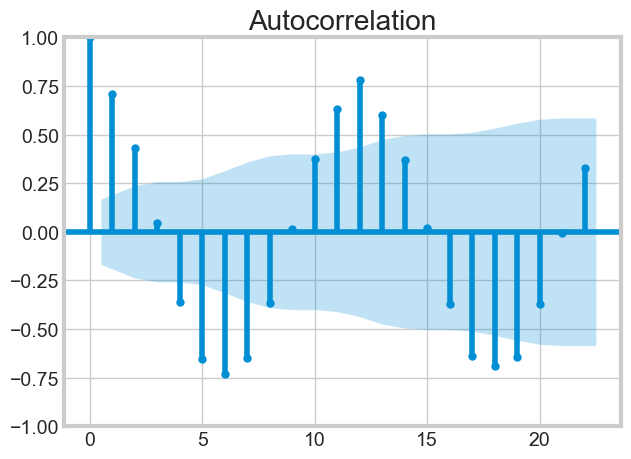

In [39]:
statsmodels.graphics.tsaplots.plot_acf(y_train)
plt.show()

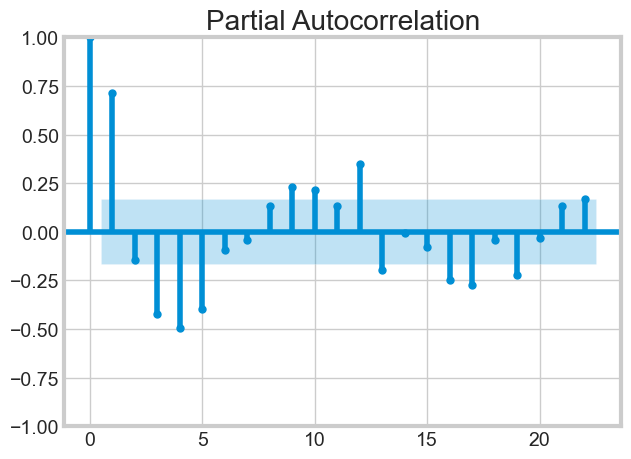

In [40]:
statsmodels.graphics.tsaplots.plot_pacf(y_train)
plt.show()

# Final Data

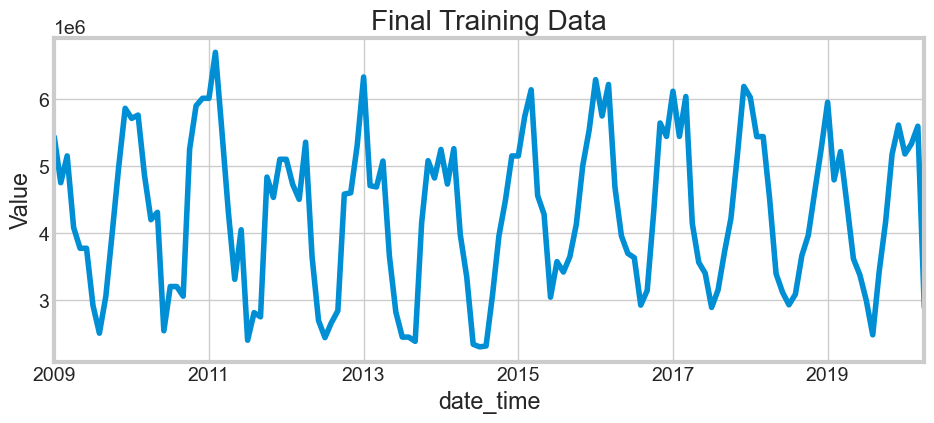

In [41]:
fig, ax = plt.subplots()
y_train_with_anom.plot(ax=ax)
fig.set_size_inches(10, 4)
ax.set_title("Final Training Data")
ax.set_ylabel("Value")
plt.show()

In [42]:
print("train_target index:", y_train.index)
print("train_exogenous index:", X_train.index)

train_target index: DatetimeIndex(['2009-01-01', '2009-02-01', '2009-03-01', '2009-04-01',
               '2009-05-01', '2009-06-01', '2009-07-01', '2009-08-01',
               '2009-09-01', '2009-10-01',
               ...
               '2019-07-01', '2019-08-01', '2019-09-01', '2019-10-01',
               '2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01'],
              dtype='datetime64[ns]', name='date_time', length=136, freq=None)
train_exogenous index: DatetimeIndex(['2009-01-01', '2009-02-01', '2009-03-01', '2009-04-01',
               '2009-05-01', '2009-06-01', '2009-07-01', '2009-08-01',
               '2009-09-01', '2009-10-01',
               ...
               '2019-07-01', '2019-08-01', '2019-09-01', '2019-10-01',
               '2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01'],
              dtype='datetime64[ns]', name='date_time', length=136, freq=None)


In [43]:
# only if required

# train_exogenous = exog_data.iloc[train_index]

# X_train = X_train[X_train.index >= '2009-02-01']
# X_train.head(5)

# MODEL

# 1. SARIMA - not used

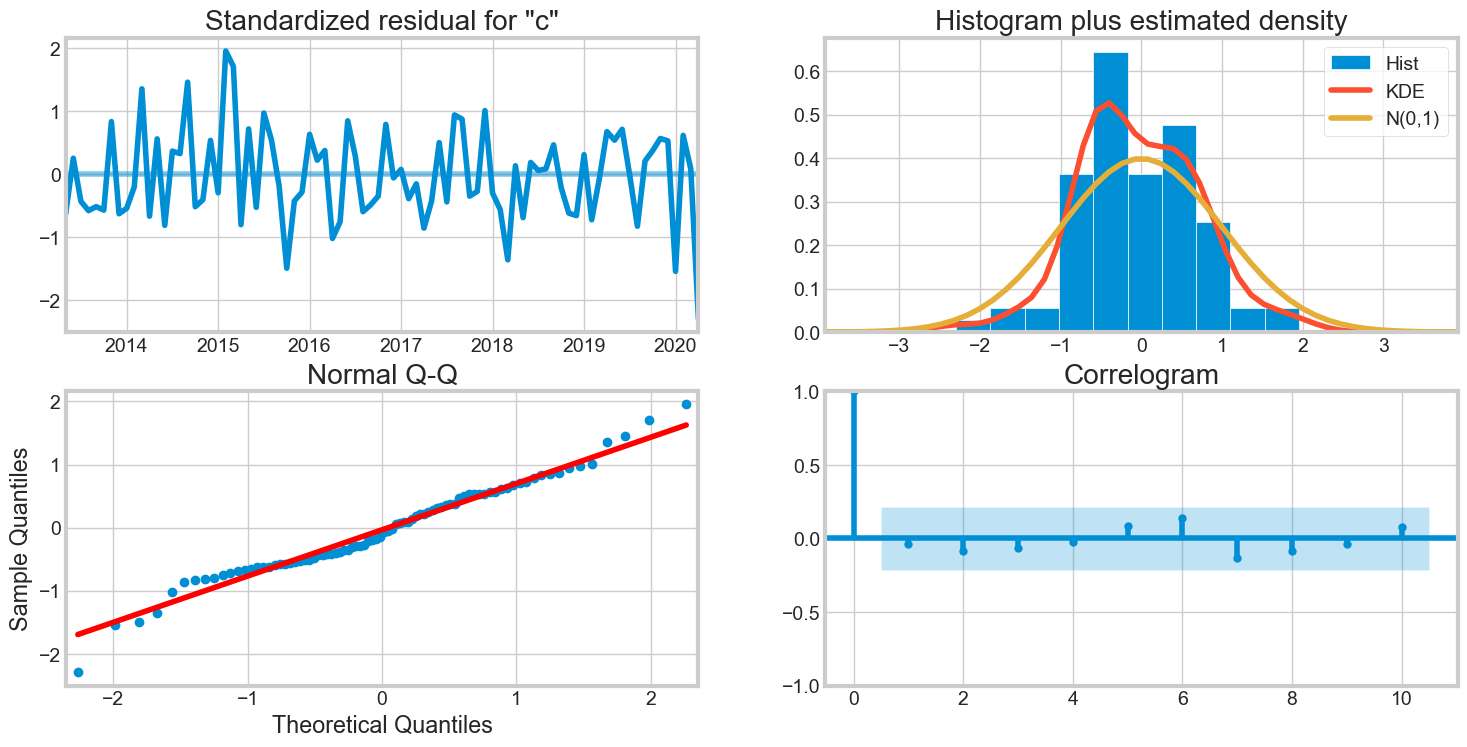

In [44]:
model1 = SARIMAX(y_train_with_anom, order=(3, 1, 0), seasonal_order=(3, 1 ,0, 12), 
                 enforce_stationarity=False, enforce_invertibility=False)

results1 = model1.fit()

results1.plot_diagnostics(figsize=(16, 8))
plt.show()

In [45]:
results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        consumption   No. Observations:                  136
Model:             SARIMAX(3, 1, 0)x(3, 1, 0, 12)   Log Likelihood               -1217.640
Date:                            Fri, 08 Sep 2023   AIC                           2449.280
Time:                                    13:30:39   BIC                           2466.295
Sample:                                01-01-2009   HQIC                          2456.120
                                     - 04-01-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7098      0.224     -3.172      0.002      -1.148      -0.271
ar.L2         -0.5164      0.250     -2.066      0.039      -1.006      -0.027
ar.L3         -0.2879      0.210     -1.371      0.170      -0.699       0.124
ar.S.L12      -0.4734      0.256     -1.849      0.064      -0.975       0.028
ar.S.L24      -0.3765      0.210     -1.792      0.073      -0.788       0.035
ar.S.L36      -0.0578      0.166     -0.349      0.727      -0.382       0.267
sigma2      3.617e+11   1.88e-13   1.92e+24      0.000    3.62e+11    3.62e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):                 0.82
Prob(Q):                              0.73   Prob(JB):                         0.66
Heteroskedasticity (H):               0.81   Skew:                             0.04
Prob(H) (two-sided):                  0.58   Kurtosis:                         3.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.19e+38. Standard errors may be unstable.
"""

# 2. SARIMAX

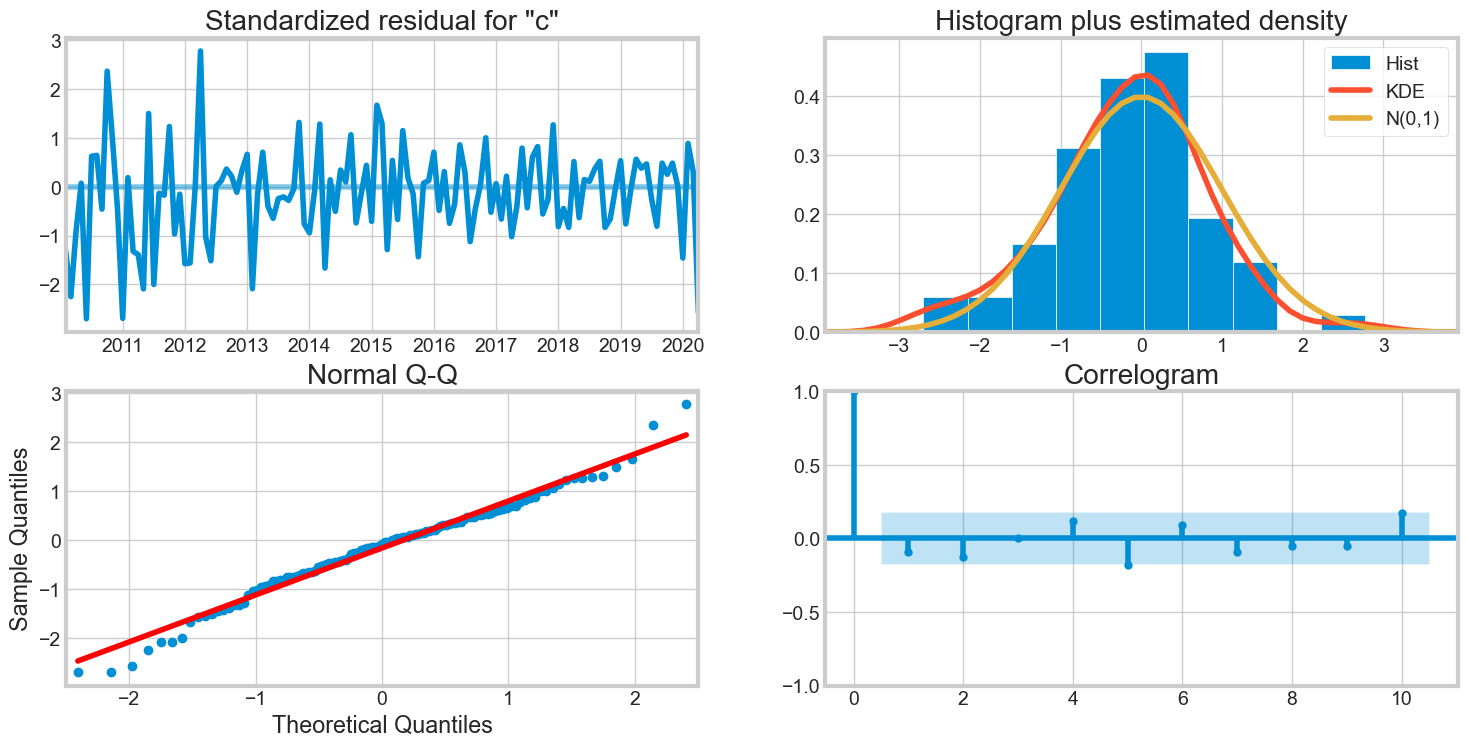

In [46]:
model2 = sm.tsa.statespace.SARIMAX(y_train_with_anom, exog=X_train,
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=True,
                                enforce_invertibility=True)
results2 = model2.fit()

results2.plot_diagnostics(figsize=(16, 8))
plt.show()

In [47]:
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        consumption   No. Observations:                  136
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1813.671
Date:                            Fri, 08 Sep 2023   AIC                           3641.342
Time:                                    13:30:39   BIC                           3661.027
Sample:                                01-01-2009   HQIC                          3649.338
                                     - 04-01-2020                                         
Covariance Type:                              opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
day_of_week -1.575e+04    2.4e+04     -0.656      0.512   -6.28e+04    3.13e+04
year            0.0015   1708.582   8.75e-07      1.000   -3348.758    3348.761
month        1.075e-05   3.03e+05   3.54e-11      1.000   -5.95e+05    5.95e+05
quarter      4.036e-06   6.89e+05   5.86e-12      1.000   -1.35e+06    1.35e+06
ma.L1          -0.4149      0.089     -4.637      0.000      -0.590      -0.240
ma.S.L12       -0.6168      0.097     -6.365      0.000      -0.807      -0.427
sigma2         3.9e+11      4.040   9.65e+10      0.000     3.9e+11     3.9e+11
===================================================================================
Ljung-Box (L1) (Q):                   1.02   Jarque-Bera (JB):                 2.81
Prob(Q):                              0.31   Prob(JB):                         0.25
Heteroskedasticity (H):               0.32   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.65e+26. Standard errors may be unstable.
"""

# 3. AUTO ARIMA

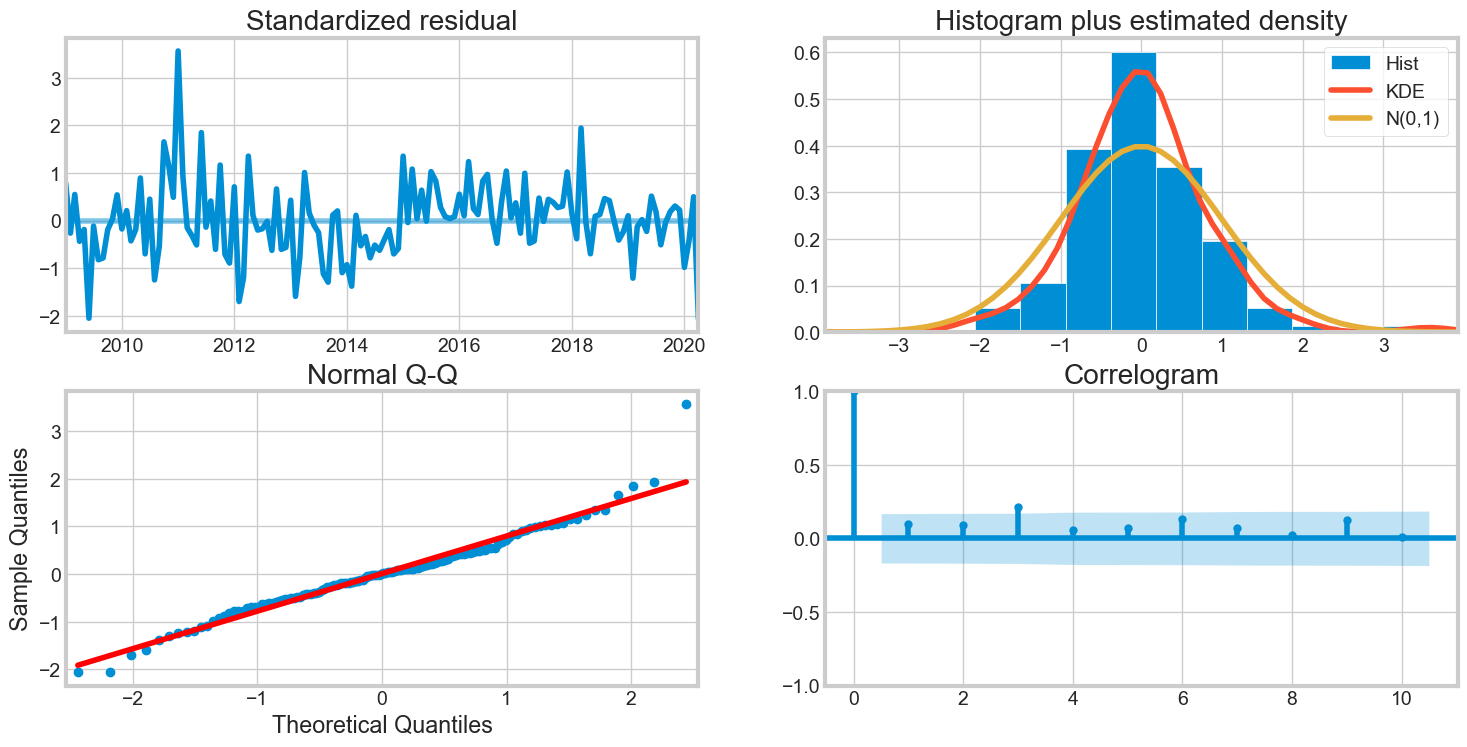

In [48]:
model3 = auto_arima(y_train_with_anom, exog=X_train,
        seasonal=True,
        stepwise=True,
        suppress_warnings=True)

results3 = model3.fit(y_train)

results3.plot_diagnostics(figsize=(16, 8))
plt.show()

In [49]:
results3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  136
Model:               SARIMAX(3, 0, 3)   Log Likelihood               -2006.784
Date:                Fri, 08 Sep 2023   AIC                           4029.569
Time:                        13:30:43   BIC                           4052.870
Sample:                    01-01-2009   HQIC                          4039.038
                         - 04-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2.289e+06   6.36e-07    3.6e+12      0.000    2.29e+06    2.29e+06
ar.L1          0.7433      0.049     15.189      0.000       0.647       0.839
ar.L2          0.7122      0.091      7.835      0.000       0.534       0.890
ar.L3         -0.9873      0.051    -19.214      0.000      -1.088      -0.887
ma.L1         -0.6968      0.139     -5.002      0.000      -0.970      -0.424
ma.L2         -0.6576      0.151     -4.342      0.000      -0.955      -0.361
ma.L3          0.9416      0.165      5.696      0.000       0.618       1.266
sigma2      5.299e+11   1.46e-13   3.62e+24      0.000     5.3e+11     5.3e+11
===================================================================================
Ljung-Box (L1) (Q):                   1.28   Jarque-Bera (JB):                42.87
Prob(Q):                              0.26   Prob(JB):                         0.00
Heteroskedasticity (H):               0.42   Skew:                             0.54
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.01e+40. Standard errors may be unstable.
"""

# 5. Exponential Smoothing

In [50]:
from statsmodels.tsa.api import ExponentialSmoothing

model5 = ExponentialSmoothing(y_train_with_anom, seasonal='mul', seasonal_periods=12, 
                                  initialization_method='heuristic')
results5 = model5.fit()

In [51]:
results5.summary()

Dep. Variable:,consumption,No. Observations:,136
Model:,ExponentialSmoothing,SSE,30600656227774.656
Optimized:,True,AIC,3582.957
Trend:,None,BIC,3623.734
Seasonal:,Multiplicative,AICC,3587.528
Seasonal Periods:,12,Date:,"Fri, 08 Sep 2023"
Box-Cox:,False,Time:,13:30:43
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.1464286,alpha,True
smoothing_seasonal,0.1969780,gamma,True


# PREDICTIONS

In [52]:
predictions2 = results2.get_prediction(start=len(y_train_with_anom), end=len(y_train_with_anom) + len(y_test) - 1, 
                                       exog=X_test).predicted_mean

predictions3 = pd.Series(model3.predict(len(y_test)))

predictions5 = results5.forecast(steps=len(y_test))

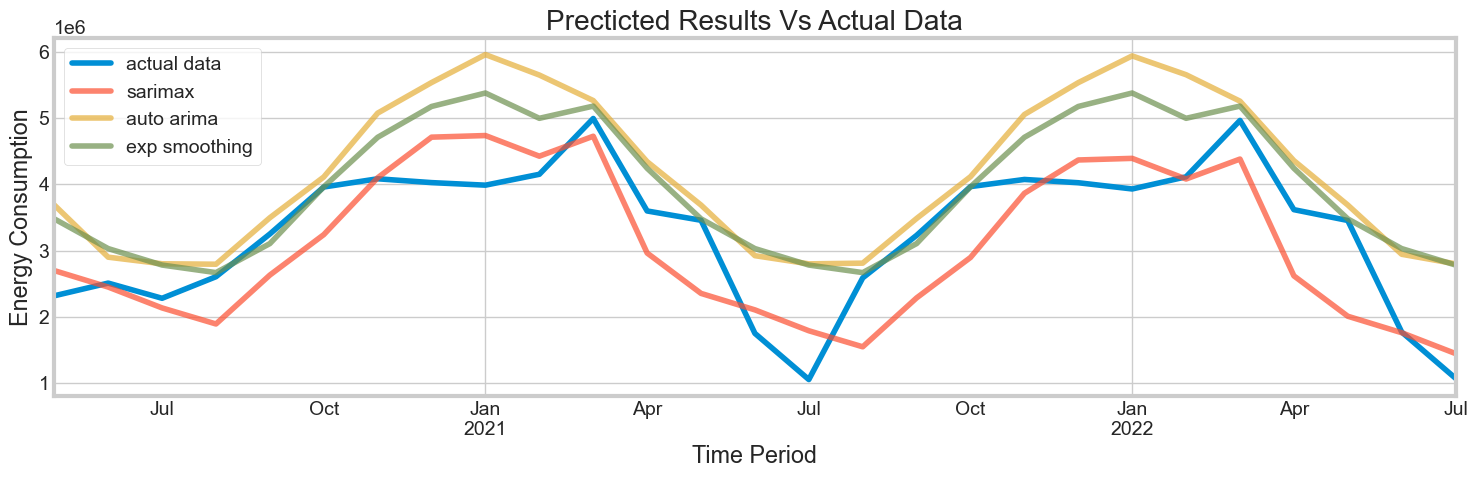

In [53]:
# ax = df['consumption'].plot(label='actual data')

ax = y_test.plot(label='actual data')

predictions2.plot(ax=ax, label='sarimax', alpha=.7, figsize=(15,5))
predictions3.plot(ax=ax, label='auto arima', alpha=.7, figsize=(15,5))
predictions5.plot(ax=ax, label='exp smoothing', alpha=.7, figsize=(15,5))

ax.set_xlabel('Time Period')
ax.set_ylabel('Energy Consumption')
plt.title("Precticted Results Vs Actual Data")
plt.tight_layout()
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.legend()
plt.show()

# Evaluation

In [54]:
mape2, smape2, mae2, rmse2 = eval_metrics(y_test, predictions2)
mape3, smape3, mae3, rmse3 = eval_metrics(y_test, predictions3)
mape5, smape5, mae5, rmse5 = eval_metrics(y_test, predictions5)

In [55]:
from tabulate import tabulate

eval_data = [['Sarimax', f'{mape2:.2f}', f'{smape2:.2f}', f'{mae2:.2f}', f'{rmse2:.2f}'],
             ['Auto-Arima', f'{mape3:.2f}', f'{smape3:.2f}', f'{mae3:.2f}', f'{rmse3:.2f}'],
             ['Exp Smoothing', f'{mape5:.2f}', f'{smape5:.2f}', f'{mae5:.2f}', f'{rmse5:.2f}'],
            ['Prophet', 0.25, 19.79, 644873.69, 809373.66]] # from prophet predictions on the prophet.ipynb file

headers = ["MODEL", "MAPE", "SMAPE", "MAE", "RMSE"]

table = tabulate(eval_data, headers=headers, tablefmt="pretty")
print(table)

+---------------+------+-------+-----------+------------+
|     MODEL     | MAPE | SMAPE |    MAE    |    RMSE    |
+---------------+------+-------+-----------+------------+
|    Sarimax    | 0.19 | 19.96 | 555085.86 | 670298.49  |
|  Auto-Arima   | 0.36 | 26.24 | 883735.66 | 1085635.71 |
| Exp Smoothing | 0.30 | 22.11 | 683166.61 | 880906.59  |
|    Prophet    | 0.25 | 19.79 | 644873.69 | 809373.66  |
+---------------+------+-------+-----------+------------+


# Forecast

In [56]:
# Forecast 5 years
yrs = 5
forecast_steps = 12 * yrs
extended_X_test = np.concatenate((X_test, np.zeros((forecast_steps - len(X_test), X_test.shape[1]))))


pred_2 = results2.get_forecast(steps=forecast_steps, exog=extended_X_test).predicted_mean
pred_3 = results3.predict(n_periods=forecast_steps)
pred_5 = results5.forecast(steps=forecast_steps)

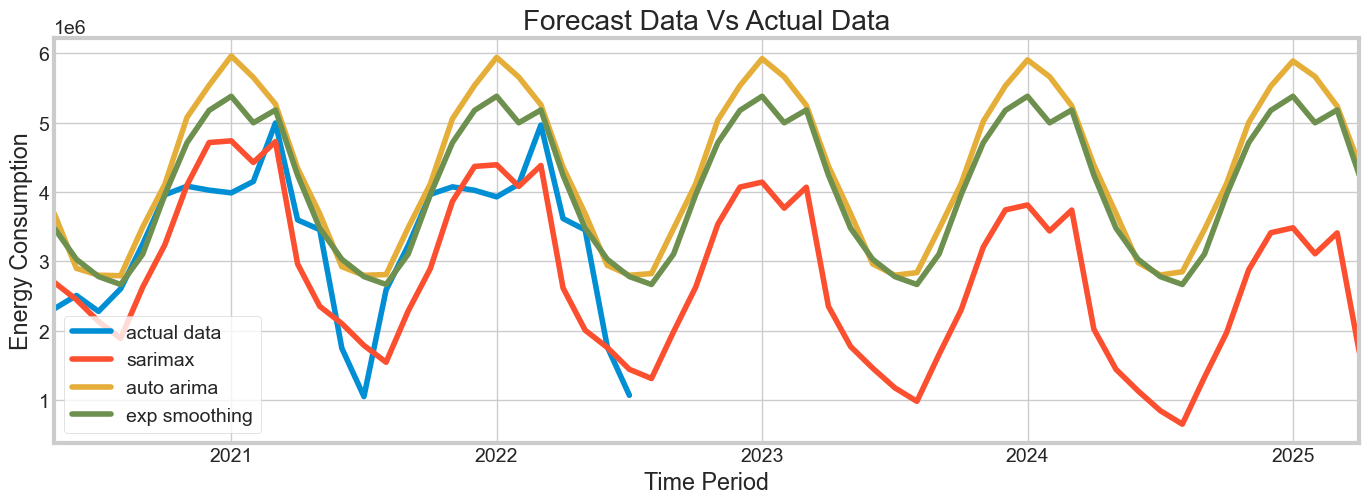

In [57]:
plt.figure(figsize=(20, 8))
ax = y_test.plot(label='actual data', figsize=(15, 5))

pred_2.plot(ax=ax, label='sarimax', figsize=(15, 5))
pred_3.plot(ax=ax, label='auto arima', figsize=(15, 5))
pred_5.plot(ax=ax, label='exp smoothing', figsize=(15, 5))

ax.set_xlabel('Time Period')
ax.set_ylabel('Energy Consumption')
plt.title("Forecast Data Vs Actual Data")
plt.legend()
# loc='upper left', bbox_to_anchor=(1, 1)
plt.show()

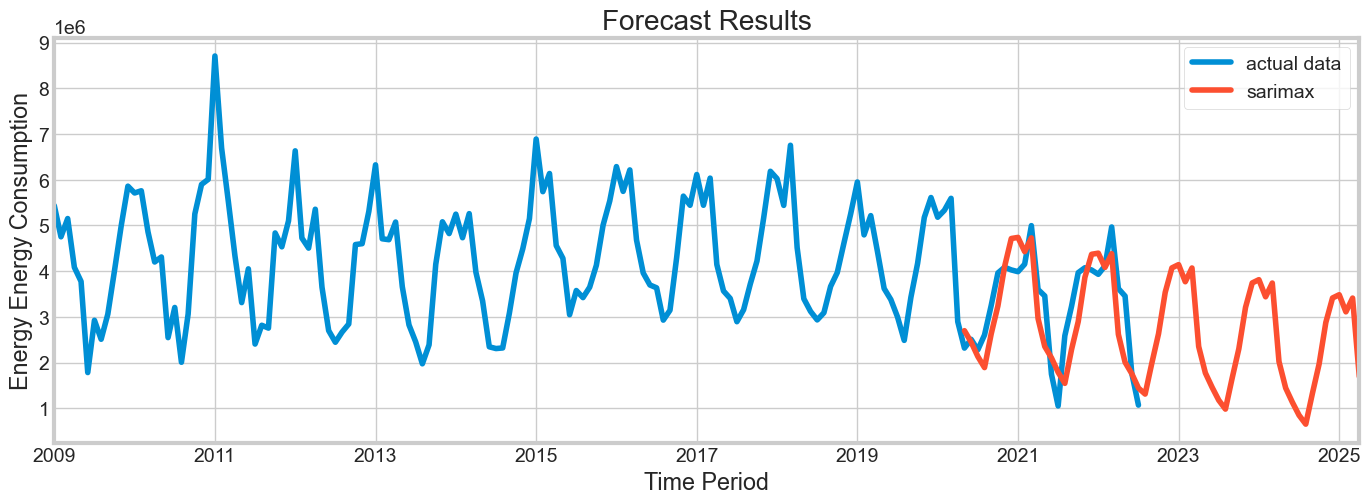

In [58]:
# Final model Forecast

plt.figure(figsize=(20, 8))
ax = df['consumption'].plot(label='actual data', figsize=(15, 5))
pred_2.plot(ax=ax, label='sarimax', figsize=(15, 5))

ax.set_xlabel('Time Period')
ax.set_ylabel('Energy Energy Consumption')
plt.title("Forecast Results")
plt.legend()
plt.show()

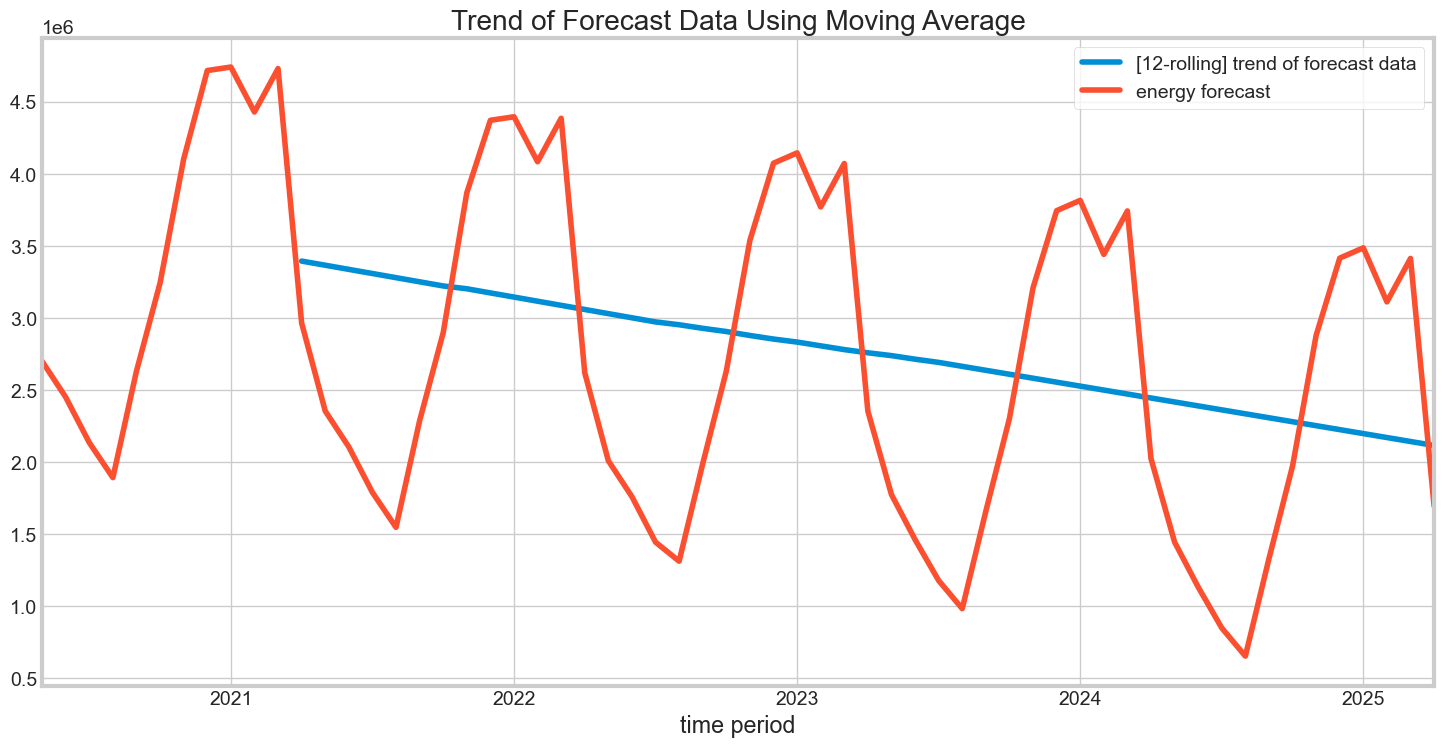

In [59]:
pred_2.rolling(12).mean().plot(label='[12-rolling] trend of forecast data',figsize=(16,8))
pred_2.plot(label='energy forecast')

plt.title("Trend of Forecast Data Using Moving Average")
plt.xlabel("time period")
plt.legend()

In [60]:
# forecasted values
pred_2

2020-05-01    2.698940e+06
2020-06-01    2.449905e+06
2020-07-01    2.134610e+06
2020-08-01    1.892165e+06
2020-09-01    2.631092e+06
2020-10-01    3.242037e+06
2020-11-01    4.101272e+06
2020-12-01    4.714858e+06
2021-01-01    4.739205e+06
2021-02-01    4.427257e+06
2021-03-01    4.728655e+06
2021-04-01    2.964183e+06
2021-05-01    2.354063e+06
2021-06-01    2.105028e+06
2021-07-01    1.789734e+06
2021-08-01    1.547288e+06
2021-09-01    2.286215e+06
2021-10-01    2.897161e+06
2021-11-01    3.866643e+06
2021-12-01    4.369981e+06
2022-01-01    4.394328e+06
2022-02-01    4.082380e+06
2022-03-01    4.383779e+06
2022-04-01    2.619306e+06
2022-05-01    2.009187e+06
2022-06-01    1.760152e+06
2022-07-01    1.444857e+06
2022-08-01    1.312655e+06
2022-09-01    1.988584e+06
2022-10-01    2.631029e+06
2022-11-01    3.537513e+06
2022-12-01    4.072350e+06
2023-01-01    4.143946e+06
2023-02-01    3.769000e+06
2023-03-01    4.070398e+06
2023-04-01    2.353175e+06
2023-05-01    1.774554e+06
2

# References
https://online.stat.psu.edu/stat510/lesson/4/4.1 </br>
https://towardsdatascience.com/time-series-forecast-in-python-using-sarimax-and-prophet-c970e6056b5b </br>
https://towardsai.net/p/data-visualization/electricity-production-forecasting-using-arima-model-in-python </br>
https://stephenallwright.com/rmse-vs-mape/</br>
https://www.statsmodels.org/dev/examples/notebooks/generated/exponential_smoothing.html </br>
https://www.section.io/engineering-education/missing-values-in-time-series/ </br>
https://medium.com/@soumyachess1496/cross-validation-in-time-series-566ae4981ce4